Here we explore cleaning visibilities with the HERA delay response observed in simulations.

In [29]:
%matplotlib inline
workdir='../data/feedSim_hera_wideBand/'
c=3e8

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal
from matplotlib import gridspec
import cosmology 
import getPower
import interferometer
littleh=0.68
import aipy 
import numpy.fft as fft

In [37]:
print cosmology

<module 'cosmology' from 'cosmology.pyc'>


In [59]:
uvw=np.load(workdir+'uvw_0.npy')
freqs=np.load(workdir+'freqs.npy')
delays=np.load(workdir+'delays.npy')
model_ion=np.load(workdir+'cont_0_model.npy')
model=np.load(workdir+'true_0_model.npy')
beamP=np.load(workdir+'beamPs.npy')
chanN=np.load(workdir+'bandnums.npy')
#srcs=np.load(workdir+'srcs_0_2014_10_24.npy')
print uvw.shape
print model.shape
print model[0,1]
nf=len(freqs)
df=freqs[1]-freqs[0]
fc=freqs[nf/2]
z=cosmology.f2z(fc)
model_ion_list=[]
model_list=[]
model_resid_list=[]
freq_list=[]
nf_list=[]
fc_list=[]
band_list=[]
beam_list0=[]
beam_list1=[]
z_list=[]
delay_list=[]
base=0
print model_ion.shape
for mm in range(len(chanN)):
    nf_list.append(chanN[mm])
    freq_list.append(freqs[base:(base+nf_list[mm])])
    fc_list.append(freq_list[mm][nf_list[mm]/2])
    model_ion_list.append(model_ion[base:(base+chanN[mm]),:])
    model_list.append(model[base:base+chanN[mm],:])
    model_resid_list.append(model_ion_list[mm]-model_list[mm])
    band_list.append(freq_list[mm][-1]-freq_list[mm][0])
    beam_list0.append(beamP[base:(base+chanN[mm]),0])
    beam_list1.append(beamP[base:(base+chanN[mm]),1])
    z_list.append(cosmology.f2z(fc_list[mm]))
    delay_list.append(1./(df*nf_list[mm])*np.arange(-nf_list[mm]/2,nf_list[mm]/2))
    base+=nf_list[mm]
    
    

(171, 3)
(1000, 171)
(-2.68573631486-17.948484537j)
(1000, 171)


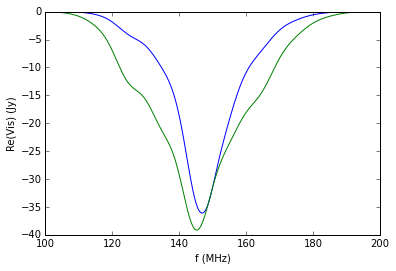

In [60]:
plt.plot(freqs/1e6,model_ion_list[0][:,5]*signal.blackmanharris(model_ion_list[0].shape[0]))
plt.plot(freqs/1e6,model_list[0][:,5]*signal.blackmanharris(model_ion_list[0].shape[0]))
plt.xlabel('f (MHz)')
plt.ylabel('Re(Vis) (Jy)')

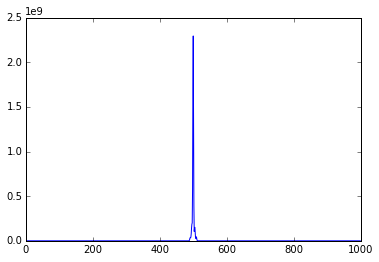

In [61]:
window=signal.blackmanharris(model_ion_list[0].shape[0])
window=window/np.sqrt(np.mean(window**2.))
plt.plot(df*np.abs(fft.fftshift(fft.fft(fft.fftshift(model_list[0][:,5]*window)))))

In [62]:
print beamP.shape

(1000, 2)


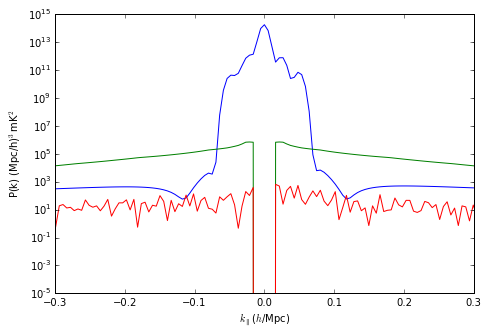

In [63]:
#plot single baseline
delayList=fft.fftshift(fft.fftfreq(len(freqs),freqs[1]-freqs[0]))
kList=cosmology.eta2kpara(delayList,cosmology.f2z(150e6))

#get the power spectrum
psVis=getPower.ps21(np.abs(kList),cosmology.f2z(150e6),flux=True,beampp=beamP[500,1])*(window.sum()*df)
#print psVis
#generat signal
signal21=(np.random.randn(len(kList))+np.random.randn(len(kList))*1j)*np.sqrt(psVis)
ps21=(littleh**3.*(cosmology.X(f0)**2.*cosmology.Y(f0)*np.abs(cosmology.i2t(f0,signal21))**2.))/(window.sum()*df*beamP[500,1])
window=signal.blackmanharris(len(delayList))
window=window
fG=fft.fftshift(fft.fft(fft.fftshift(window*model_list[0][:,5])))*df
f0=freqs[len(freqs)/2]
z0=cosmology.f2z(f0)
fG=fG/np.sqrt(beam_list1[0]*window.sum()*df)
fG=littleh**3.*(cosmology.X(f0)**2.*cosmology.Y(f0)*np.abs(cosmology.i2t(f0,fG))**2.)*1e6
plt.plot(kList/littleh,np.abs(fG),label='Foregrounds')
plt.plot(kList/littleh,littleh**3.*getPower.ps21(np.abs(kList),z0*np.ones(len(delayList))),label='Signal')
plt.plot(kList/littleh,ps21)
plt.yscale('log')
plt.xlim(-.3,.3)
plt.ylabel("P(k) (Mpc/h)$^3$mK$^2$")
plt.xlabel('$k_\parallel$ ($h$/Mpc)')
plt.gcf().set_size_inches(7.5,5)

In [68]:
#data,window,kernel,area are all given in zero in center format real space.
def tsys(f):
    return 100.+60.*(c/f)**2.55
def gen_noise(fAxis,tau,ae):
    noiseAmp=np.sqrt(2.)*1.23e3*tsys(fAxis)/(ae*np.sqrt(tau*(fAxis[1]-fAxis[0])))
    return noiseAmp*(np.random.randn(len(fAxis))+1j*np.random.randn(len(fAxis)))
def delay_clean(data,window,kernel,area,tol=1e-3,gain=.1,maxiter=1000):
    dDelay=fft.ifft(data*window)
    dKernel=fft.ifft(kernel)
    area=fft.fftshift(area)
    cc,info=aipy.deconv.clean(dDelay,dKernel,area=area,tol=tol,gain=gain,maxiter=maxiter,stop_if_div=False,verbose=False)
    return fft.fft(info['res'])

def delay_clean_gentle(data,window,kernel,area,nsigma=3.):
    dDelay=fft.ifft(data*window)
    dKernel=fft.ifft(kernel)
    area=fft.fftshift(area).astype(int)
    noiseArea=(1.-area).astype(int)
    noiseSTD=np.sqrt(np.mean(np.abs(dDelay[noiseArea==1])**2.))
    signalSTD=np.sqrt(np.mean(np.abs(dDelay[area==1]))**2.)
    good=signalSTD>=nsigma*noiseSTD
    iters=0
    #print good
    #print noiseSTD
    #print signalSTD
    while(good):
        iters+=1
        cc,info=aipy.deconv.clean(dDelay,dKernel,area=area,tol=1e-3,gain=.1,maxiter=int(1e3),stop_if_div=False,verbose=False)
        signalSTD=np.sqrt(np.mean(np.abs(info['res'][area==1])**2.))
        noiseSTD=np.sqrt(np.mean(np.abs(info['res'][noiseArea==1])**2.))
        #plt.plot(np.abs(fft.fftshift(info['res'])))
        #plt.yscale('log')
        #plt.show()
        #print 'comparison'
        #print noiseSTD
        #print signalSTD
        good=signalSTD>=nsigma*noiseSTD
        if(good):
            dDelay=info['res']

    #print iters 
    return fft.fft(dDelay)



In [99]:
#clean residuals
model_ion_resid=[]
model_resid=[]
model_resid_noisy=[]
window_ion=signal.blackmanharris(model_ion_list[0].shape[0])
window=signal.blackmanharris(model_list[0].shape[0])
window_ion=window_ion/np.sqrt(np.mean(window_ion**2.))
winow=window/np.sqrt(np.mean(window**2.))
kernel=np.ones(len(model_list[0]))
noise=gen_noise(freqs,2.*60.,75.)
for mm in range(model_ion_list[0].shape[1]):
    tuvw=uvw[mm,:]
    maxdelay=np.sqrt(np.sum(tuvw**2.))/c+cosmology.kpara2eta(0.1,z)
    area=np.zeros(len(model_list[0]))
    area[np.abs(delays)<maxdelay]=1.
    temp=delay_clean_gentle(model_list[0][:,mm]+noise,window,kernel,area)
    model_resid_noisy.append(temp)
    model_resid.append((temp-noise*window)/window)
    model_ion_resid.append((delay_clean_gentle(model_ion_list[0][:,mm]+noise,window_ion,kernel,area)-noise*window_ion)/window_ion)
model_ion_resid=np.array(model_ion_resid).T
model_resid=np.array(model_resid).T
model_resid_noisy=np.array(model_resid_noisy).T

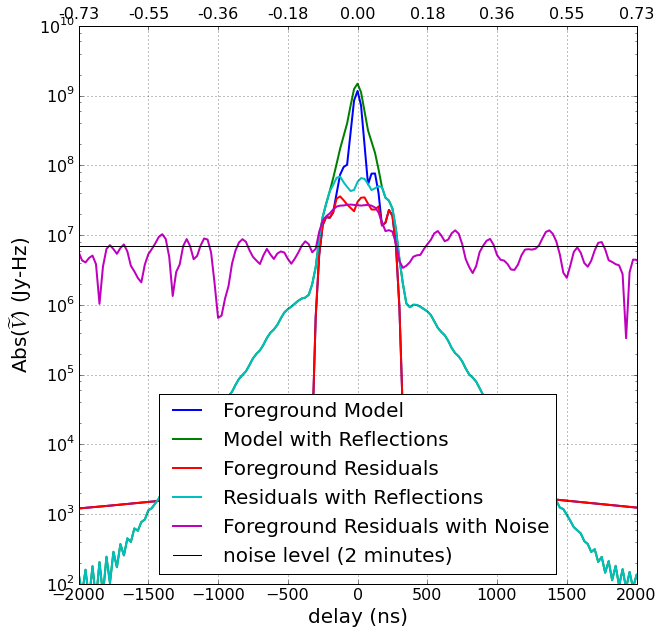

In [116]:
l1=plt.plot(delays*1e9,df*np.abs(fft.fftshift(fft.fft(model_list[0][:,5]*window))),lw=2,label='Foreground Model')[0]
l2=plt.plot(delays*1e9,df*np.abs(fft.fftshift(fft.fft(model_ion_list[0][:,5]*window_ion))),lw=2,label='Model with Reflections')[0]



l3=plt.plot(delays*1e9,df*np.abs(fft.fftshift(fft.fft(model_resid[:,5]*window))),lw=2,label='Foreground Residuals')[0]
l4=plt.plot(delays*1e9,df*np.abs(fft.fftshift(fft.fft(model_ion_resid[:,5]*window_ion))),lw=2,label='Residuals with Reflections')[0]

l5=plt.plot(delays*1e9,df*np.abs(fft.fftshift(fft.fft(model_resid_noisy[:,5]*window))),lw=2,label='Foreground Residuals with Noise')[0]
#plt.plot(delays*1e9,df*np.abs(fft.fftshift(fft.fft(noise*window)),'noise'))
l6=plt.axhline(7e6,color='k',label='noise level (2 minutes)')[0]
plt.legend(loc='lower center',fontsize=20)
plt.ylim(1e2,1e10)
plt.xlim(-2000,2000)
plt.gcf().set_size_inches(10,10)
plt.grid()
plt.yscale('log',fontsize=20)
plt.xlabel('delay (ns)',fontsize=20)
plt.ylabel('Abs($\\widetilde{V}$) (Jy-Hz)',fontsize=20)
ax1=plt.gca()
ax1.tick_params('x',labelsize=16)
ax1.tick_params('y',labelsize=16)
ax2=ax1.twiny()
ticks=ax1.get_xticks()
labels=[]
for tick in ticks:
    labels.append('%.2f'%(cosmology.eta2kpara(tick/1e9,cosmology.f2z(150e6))))
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels)
ax2.tick_params('x',labelsize=16)
ax2.tick_params('y',labelsize=16)
plt.savefig('../paper/figures/cleaning_noise.pdf')

In [93]:
#load HERA Array and get noise for a 32 minute integration
antpos=np.loadtxt('line40_hybrid_spaced.txt')
hera=interferometer.getMRO(antpos,freqs)
hera.phasezenith()
hera.pointzenith()
noise_list=[]
for mm in range(len(fc_list)):
    noise=hera.delayNoise(250.,100*32.*60.,fc_list[mm])
    noise,_=np.meshgrid(noise,range(nf_list[mm]))
    noise_list.append(noise)

IOError: [Errno 2] No such file or directory: 'line40_hybrid_spaced.txt'

In [94]:

def plotps2d_list(xlist,ylist,datalist,title,xlabel,ylabel,vmin=2,vmax=19):
    if(len(datalist)>1):
        fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
    else:
        fig,axarr=plt.subplots(2,1,sharex=True,sharey=True)

    for mm in range(2):
        for nn in range(len(datalist)):
            im=axarr[mm][nn].imshow(np.log10(datalist[mm]),interpolation='nearest',extent=[xlist[mm].min(),xlist[mm].max(),ylist[mm].min(),ylist[mm].max()],vmin=vmin,vmax=vmax)
            axarr[mm][nn].set_title(title)
            axarr[mm][nn].set_xlabel(xlabel)
            axarr[mm][nn].set_ylabel(ylabel)
            axarr[mm][nn].set_aspect('auto','datalim')
    cax=fig.add_axes([.95,.1,.05,.8])
    fig.colorbar(im,cax=cax)
    fig.set_size_inches((len(datalist)/2*6,2*6))
def plotps2d_list_ascale(xlist,ylist,datalist,title,xlabel,ylabel):
    fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
    for mm in range(2):
        for nn in range(len(datalist)/2):
            im=axarr[mm][nn].imshow(np.log10(datalist[mm]),interpolation='nearest',extent=[xlist[mm].min(),xlist[mm].max(),ylist[mm].min(),ylist[mm].max()])
            axarr[mm][nn].set_title(title)
            axarr[mm][nn].set_xlabel(xlabel)
            axarr[mm][nn].set_ylabel(ylabel)
            axarr[mm][nn].set_aspect('auto','datalim')
    cax=fig.add_axes([.95,.1,.05,.8])
    fig.colorbar(im,cax=cax)
    fig.set_size_inches((len(datalist)/2*6,2*6))

In [119]:
def plotlist(datalist,bnum=10):
    fig,axarr=plt.subplots(1,len(datalist),sharex=True,sharey=True)
    for mm in range(len(datalist)):
        axarr[mm].plot((datalist[mm][:,bnum]))
        axarr[mm].set_aspect('auto','datalim')
    fig.set_size_inches((6*len(datalist),6))
def plotlist2(datalist1,datalist2,bnum=10):
    fig,axarr=plt.subplots(1,len(datalist1),sharex=True,sharey=True)
    for mm in range(len(datalist1)):
        axarr[mm].plot((datalist1[mm][:,bnum]))
        axarr[mm].plot((datalist2[mm][:,bnum]))
        axarr[mm].set_aspect('auto','datalim')
    fig.set_size_inches((6*len(datalist1),6))

Create binned uvw data with from visibility matrix output by simulation. vis is an nfreq x nvis x 3 complex numpy array. uvw is an nfreq x nvis  numpy array

In [120]:
def delayTransform(vis,df):
    window=signal.blackmanharris(vis.shape[0])
    #window=window/np.sqrt(np.mean(window**2.))
    windowx,windowy=np.meshgrid(range(vis.shape[1]),window)
    return window,np.fft.fftshift(np.fft.fft(np.fft.fftshift(vis*windowy,axes=0),axis=0),axes=0)*df
def delayTransformList(vislist,df):
    output=[]
    windows=[]
    for mm in range(len(vislist)):
        dT=delayTransform(vislist[mm],df)
        windows.append(dT[0])
        output.append(dT[1])
    return output,windows
def delay2PS(vis,beamP,band,f0):
    #convert to temperature power spectrum
    output=np.zeros_like(vis)
    for mm in range(vis.shape[1]):
        output[:,mm]=vis[:,mm]/np.sqrt(beamP*band)
    output=littleh**3.*(cosmology.X(f0)**2.*cosmology.Y(f0)*np.abs(cosmology.i2t(f0,output))**2.)*1e6
    return output
def delay2PSList(vislist,beamlist,bandlist,flist):
    output=[]
    for mm in range(len(vislist)):
        output.append(delay2PS(vislist[mm],beamlist[mm],bandlist[mm],flist[mm]))
    return output

In [121]:
select=np.logical_and(freqs>140e6,freqs<=160e6)
freqs_select=freqs[select]
nfs=len(freqs_select)
print model_resid.shape
band_select=freqs_select.max()-freqs_select.min()
fcs=freqs_select[len(freqs_select)/2]

dtrans_list,_=delayTransformList([model_list[0][select,:]],df)
dtrans_ion_list,_=delayTransformList([model_ion_list[0][select,:]],df)
dtrans_resid_list,_=delayTransformList([model_resid[select,:]],df)
dtrans_ion_resid_list,windows=delayTransformList([model_ion_resid[select,:]],df)


ps_list=delay2PSList(dtrans_list,[beam_list1[0][select]],[band_select*windows[0].mean()],[fcs])
ps_ion_list=delay2PSList(dtrans_ion_list,[beam_list1[0][select]],[band_select*windows[0].mean()],[fcs])
ps_resid_list=delay2PSList(dtrans_resid_list,[beam_list1[0][select]],[band_select*windows[0].mean()],[fcs])
ps_ion_resid_list=delay2PSList(dtrans_ion_resid_list,[beam_list1[0][select]],[band_select*windows[0].mean()],[fcs])

(1000, 171)


7.00466666667
['', '', '-0.8', '', '', '', '-0.4', '', '', '', '0.0', '', '', '', '0.4', '', '', '', '0.8', '', '']
[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]


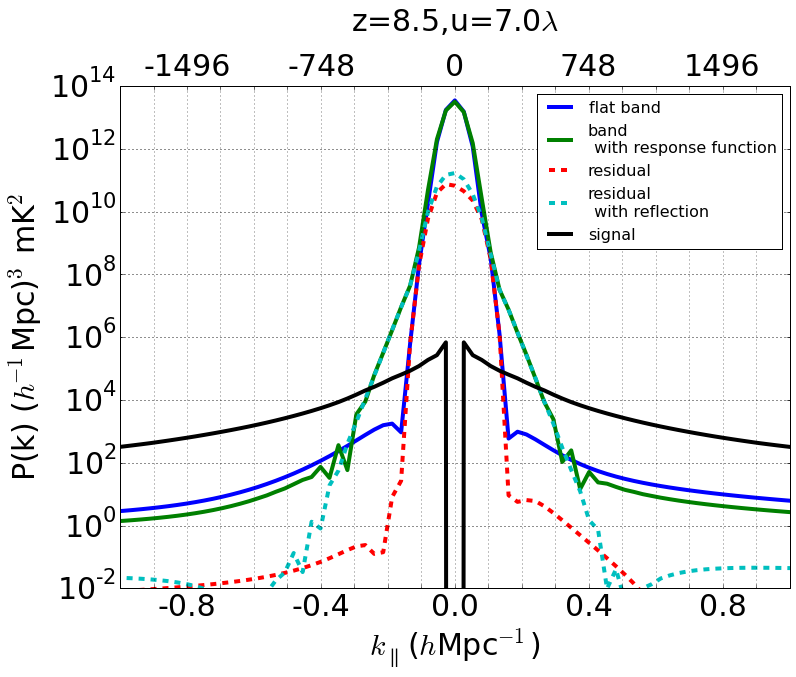

In [130]:
index=5
z0=cosmology.f2z(fcs)
tuvw=uvw[index,:]
uvw_l=np.sqrt(np.sum(tuvw**2.))/c*freqs_select[nfs/2]
print uvw_l
delayList=np.arange(-nfs/2,nfs/2)/(nfs*df)
#print cosmology.eta2kpara(np.abs(delayList),z0)
#print ps_resid_list[0].shape
kList=cosmology.eta2kpara((delayList),z0)
plt.plot(kList/littleh,ps_list[0][:,index],label='flat band',lw=4)
plt.plot(kList/littleh,ps_ion_list[0][:,index],label='band\n with response function',lw=4)
plt.plot(kList/littleh,ps_resid_list[0][:,index],label='residual',ls='--',lw=4)
plt.plot(kList/littleh,ps_ion_resid_list[0][:,index],label='residual\n with reflection',ls='--',lw=4)



hz=cosmology.eta2kpara(uvw_l/freqs_select[nfs/2],z0)/littleh
#plt.axvline(-hz+.1,color='k',ls='--')
#plt.axvline(hz+.1,color='k',ls='--')
#print getPower.ps21(cosmology.eta2kpara(np.abs(delayList),z0),z0*np.ones(len(delayList)))
plt.plot(kList/littleh,littleh**3.*getPower.ps21(cosmology.eta2kpara(np.abs(delayList),z0),z0*np.ones(len(delayList))),color='k',lw=4,label='signal')
plt.yscale('log')
plt.xlabel('$k_\parallel$ ($h$Mpc$^{-1}$)',fontsize=30)
plt.ylabel('P(k) ($h^{-1}$Mpc)$^{3}$ mK$^2$',fontsize=30)
plt.legend(loc='upper right',fontsize=16)
plt.gcf().set_size_inches(10,10)
plt.title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fcs),uvw_l),fontsize=30,y=1.1)
plt.gca().tick_params('x',labelsize=30)
plt.gca().tick_params('y',labelsize=30)
#plt.grid(True)
#plt.subgrid(True)
#plt.axvline(.1,color='k',ls=':',lw=.5)
#plt.axvline(.2,color='k',ls=':',lw=.5)
#plt.axvline(.3,color='k',ls=':',lw=.5)

plt.grid(b=True,which='major')
plt.grid(b=True,which='minor')
plt.xlim(-1.,1.)
plt.ylim(1e-2,1e14)


tickset=np.arange(-10,11)*.1
plt.gca().set_xticks(tickset)
labels=[]
for tick in tickset:
    if(int(tick*10)%4==0):
        labels.append(str(tick))
    else:
        labels.append('')
print labels
print tickset
#plt.xscale('log')
plt.gca().set_xticklabels(labels)
plt.gcf().set_size_inches(12,9)
ax1=plt.gca()
ax2=ax1.twiny()
ticks=ax1.get_xticks()
labels=[]
for tick in ticks:
    if(int(tick*10)%4==0):
        labels.append('%d'%(1e9*cosmology.kpara2eta(littleh*tick,cosmology.f2z(150e6))))
    else:
        labels.append('')
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels)
ax2.tick_params('x',labelsize=30)
ax2.tick_params('y',labelsize=30)
plt.savefig('../paper/figures/resid_5sigma_compare.pdf',bbox_inches='tight')

In [133]:
print cosmology.kpara2eta(0.15*littleh,8.5)*1e9
print cosmology.kpara2eta(0.25*littleh,8.5)*1e9

281.014521471
468.357535786


In [ ]:
index=5
z0=cosmology.f2z(fc_list[0])
tuvw=uvw[index,:]
uvw_l=np.sqrt(np.sum(tuvw**2.))/c*freqs[nf/2]
print uvw_l
delayList=np.arange(-nf/2,nf/2)/(nf*df)
#print cosmology.eta2kpara(np.abs(delayList),z0)
#print ps_resid_list[0].shape
kList=cosmology.eta2kpara((delayList),z0)
plt.plot(kList,ps_list[0][:,index],label='flat band')
plt.plot(kList,ps_ion_list[0][:,index],label='band with response function')
plt.plot(kList,ps_resid_list[0][:,index],label='residual',ls='--')


hz=cosmology.eta2kpara(uvw_l/freqs[nf/2],z0)/littleh
#plt.axvline(-hz+.1,color='k',ls='--')
plt.axvline(hz+.1,color='k',ls='--')
#print getPower.ps21(cosmology.eta2kpara(np.abs(delayList),z0),z0*np.ones(len(delayList)))
plt.plot(kList,littleh**3.*getPower.ps21(cosmology.eta2kpara(np.abs(delayList),z0),z0*np.ones(len(delayList))),label='signal')
plt.yscale('log')
plt.xlabel('$k_\parallel$ ($h$Mpc$^{-1}$)',fontsize=30)
plt.ylabel('P(k) ($h^{-1}$Mpc)$^{3}$ mK$^2$',fontsize=30)
plt.legend(loc='best')
plt.gcf().set_size_inches(10,10)
plt.title('z=%.1f,u=%.1f$\\lambda$'%(cosmology.f2z(fc),uvw_l),fontsize=30)
plt.gca().tick_params('x',labelsize=20)
plt.gca().tick_params('y',labelsize=20)
plt.xlim(3e-2,2.5)
plt.xscale('log')

plt.savefig('../../spec_memo/figures/delay_response_compare_.pdf',bbox_inches='tight')

In [ ]:
def binU(uvw,delays,data,nbins):
        u=np.sqrt(np.sum(uvw[:,:]**2.,axis=1))
        minu=u.min()
        maxu=u.max()
        du=(maxu-minu)/(nbins)
        ubins=np.zeros((data.shape[0]/2,nbins))
        etaaxis=np.zeros(data.shape[0]/2)
        counts=np.zeros(nbins)
        for mm in range(data.shape[0]/2):
            etaaxis[mm]=(np.abs(delays[data.shape[0]/2+mm])+np.abs(delays[data.shape[0]/2-mm]))/2
        for uvind in range(len(u)):
            ubin=int(np.round((u[uvind]-minu)/du))
            if(ubin>=0 and ubin<nbins):
                for mm in range(data.shape[0]/2):
                    ubins[mm,ubin]+=(data[mm+data.shape[0]/2,uvind]+data[data.shape[0]/2-mm,uvind])/2
                counts[ubin]+=1
        for m in range(nbins):
            ubins[:,m]=ubins[:,m]/counts[m]
        ubins[np.isnan(ubins)]=0.
        return np.linspace(minu,maxu,nbins),etaaxis,ubins
def binUList(uvw_list,delays_list,data_list,nbins):
    output=[]
    for mm in range(len(uvw_list)):
        output.append(binU(uvw_list[mm],delays_list[mm],data_list[mm],nbins))
    return output
def binU1D(uvw,delays,signal,weights,fc,flags,mink=1e-2,maxk=1.2,logscale=True,nbins=20):
    z=cosmology.f2z(fc)
    u=np.sqrt(np.sum(uvw[:,:]**2.,axis=1))
    kperp=cosmology.u2kperp(u,z)/littleh
    kpara=cosmology.eta2kpara(delays,z)/littleh
    kperpg,kparag=np.meshgrid(kperp,kpara)#kperp/kparallel of all visibilities
    kg=np.sqrt(kperpg**2.+kparag**2.)
    if(logscale):
        kg=np.log10(kg)
        mink=np.log10(mink)
        maxk=np.log10(maxk)
    kg=kg[flags].flatten()
    signal=signal[flags].flatten()
    weights=weights[flags].flatten()
    ps=np.zeros(nbins)
    cts=np.zeros(nbins)
    ks=np.zeros(nbins)
    dk=(maxk-mink)/nbins
    for mm in range(len(kg)):
        kbin=int((kg[mm]-mink)/dk)
        if(logscale):
            k=kg[mm]**2.
        else:
            k=kg[mm]
        if(kbin>=0 and kbin<nbins):
            ps[kbin]+=signal[mm]*weights[mm]
            cts[kbin]+=weights[mm]
            ks[kbin]+=k
    return cts,ks/cts,ps/cts

#bin the noise assuming inverse square weighting
def binNoise1D(uvw,delays,noise,fc,flags,mink=1e-2,maxk=1.,logscale=True,nbins=20):
    z=cosmology.f2z(fc)
    u=np.sqrt(np.sum(uvw[:,:]**2.,axis=1))
    kperp=cosmology.u2kperp(u,z)/littleh
    kpara=cosmology.eta2kpara(delays,z)/littleh
    kperpg,kparag=np.meshgrid(kperp,kpara)#kperp/kparallel of all visibilities
    kg=np.sqrt(kperpg**2.+kparag**2.)
    if(logscale):
        kg=np.log10(kg)
        mink=np.log10(mink)
        maxk=np.log10(maxk)
    #now apply mask
    kg=kg[flags].flatten()
    noise=noise[flags].flatten()
    ps=np.zeros(nbins)
    cts=np.zeros(nbins)
    ks=np.zeros(nbins)
    dk=(maxk-mink)/nbins
    print len(noise)
    for mm in range(len(noise)):
        kbin=int((kg[mm]-mink)/dk)
        if(logscale):
            k=10.**kg[mm]
        else:
            k=kg[mm]
        if(kbin>=0 and kbin<nbins):
            ps[kbin]+=1/noise[mm]**2.
            cts[kbin]+=1
            ks[kbin]+=k
    ps=np.sqrt(1./ps)
    ps[np.logical_or(np.isnan(ps),np.isinf(ps))]=9e99
    return cts,ks/cts,ps
    #not interate through every cell 

In [ ]:
def wedgeflag(uvw,eta,fc,offset,bfwhm):
    offset=cosmology.kpara2eta(offset/littleh,cosmology.f2z(fc))
    u=np.sqrt(np.sum(uvw[:,:-1]**2.,axis=1))
    ug,etag=np.meshgrid(u,eta)
    #plt.imshow(etag)
    #plt.colorbar()
    #plt.show()
    #plt.imshow(ug)
    #plt.colorbar()
    #plt.show()
    
    return np.abs(ug/c)<=(np.abs(etag)-offset)/np.sin(np.radians(bfwhm/2.))
flags=wedgeflag(uvw*fc_list[mm]/c,delay_list[mm],fc_list[mm],0.2,180.)


In [ ]:
cuvw_list=[]
for mm in range(len(chanN)):
    cuvw_list.append(uvw*freq_list[mm][nf_list[mm]/2]/c)
ubins_list=binUList(cuvw_list,delay_list,ps_list,15)
ubins_ion_list=binUList(cuvw_list,delay_list,ps_ion_list,15)
ubins_resid_list=binUList(cuvw_list,delay_list,ps_resid_list,15)
kperp_list=[]
kpara_list=[]
psbin_list=[]
psbin_ion_list=[]
psbin_resid_list=[]
for mm in range(len(chanN)):
    psbin_list.append(ubins_list[mm][2])
    psbin_ion_list.append(ubins_ion_list[mm][2])
    psbin_resid_list.append(ubins_resid_list[mm][2])
    kpara_list.append(cosmology.eta2kpara(ubins_list[mm][1],z_list[mm])/littleh)
    kperp_list.append(cosmology.u2kperp(ubins_list[mm][0],z_list[mm])/littleh)

In [ ]:
my_cm='afmhot'
kperpg,kparag=np.meshgrid(kperp_list[0][1:],kpara_list[0][1:])
gs=gridspec.GridSpec(7,3)
axarr=[plt.subplot(gs[:-2,mm]) for mm in range(3)]
axarr.append(plt.subplot(gs[-2:-1,:]))
axarr[0].set_title('No Reflections')
axarr[0].pcolor(kperpg,kparag,np.log10(psbin_list[0][1:,1:]),vmin=3.,vmax=16,cmap=my_cm)
axarr[0].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=3,color='w')
axarr[0].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=2,color='k',ls='-')
axarr[0].set_yscale('log')
axarr[0].set_xscale('log')
axarr[0].set_aspect('auto')
#axarr[0].set_xlabel('$k_\\perp$ h/Mpc')
#axarr[0].set_ylabel('$k_\\parallel$ h/Mpc')
axarr[0].set_xlim(1e-2,2e-1)
axarr[0].set_ylim(2e-2,3e0)

axarr[1].set_title('with reed reflection')
axarr[1].pcolor(kperpg,kparag,np.log10(psbin_ion_list[0][1:,1:]),vmin=3.,vmax=16,cmap=my_cm)
axarr[1].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=3,color='w')
axarr[1].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=2,color='k',ls='-')
axarr[1].set_yscale('log')
axarr[1].set_xscale('log')
axarr[1].set_xlim(1e-2,2e-1)
axarr[1].set_xlabel('$k_\\perp$ hMpc$^{-1}$',fontsize=14)
#axarr[1].set_ylabel('$k_\\parallel$ h/Mpc')
axarr[1].set_aspect('auto')
axarr[1].set_ylim(2e-2,3e0)

axarr[2].set_title('Residual')
im=axarr[2].pcolor(kperpg,kparag,np.log10(psbin_resid_list[0][1:,1:]),vmin=3.,vmax=16.,cmap=my_cm)
axarr[2].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=3,color='w')
axarr[2].plot(kperp_list[0],cosmology.wedge(cosmology.f2z(fc))*kperp_list[0]+.1,lw=2,color='k',ls='-')
axarr[2].set_yscale('log')
axarr[2].set_xscale('log')
axarr[2].set_xlim(1e-2,2e-1)
axarr[2].set_aspect('auto')
axarr[2].set_ylim(2e-2,3e0)
#axarr[2].set_xlabel('$k_\\perp$ h/Mpc')
axarr[0].set_ylabel('$k_\\parallel$ hMpc$^{-1}$',fontsize=14)
axarr[2].axhline(cosmology.eta2kpara(2.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='w',lw=2)
axarr[2].axhline(cosmology.eta2kpara(4.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='w',lw=2,ls='-')


axarr[2].axhline(cosmology.eta2kpara(2.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='k',lw=1)
axarr[2].axhline(cosmology.eta2kpara(4.*35./(3e8*.81),cosmology.f2z(fc))/littleh,color='k',lw=1,ls='--')



fig=plt.gcf()
#cbar_ax=fig.add_axes([0.1,0.05,.8,.05])
cbar=fig.colorbar(im,cax=axarr[-1],orientation='horizontal')
cbar.set_label('P(k) (h$^{-3}$Mpc$^{3}$)',fontsize=14)

fig.set_size_inches([15,7])
plt.tight_layout()
plt.savefig('../../spec_memo/figures/hera_reflections_EoX_feed.png',bbox_inches='tight')
'''
flaggrid=np.ones(psbin_list[0].shape)
flaggrid[flags]=1.
flaggrid[np.invert(flags)]=0.
plt.pcolor(kperpg,kparag,np.log10(psbin_list[0][1:,1:]))
plt.yscale('log')
plt.xscale('log')
plt.gca().set_aspect('auto')
'''

In [ ]:
def psgrid(kperpaxis,kparaaxis,z):
    kperpg,kparag=np.meshgrid(kperpaxis,kparaaxis)
    zs=z*np.ones(kperpg.shape)
    return getPower.ps21_c(kperpg,kparag,zs)
def psgrid_list(kperplist,kparalist,zlist):
    output=[]
    for mm in range(len(kperplist)):
        output.append(psgrid(kperplist[mm],kparalist[mm],zlist[mm]))
    return output

In [ ]:
noise1D=[]
noise1Dr=[]
resid1D=[]
signal1D=[]
klist1D=[]
ctlist1D=[]
foreground1D=[]
resid1Dr=[]
signal1Dr=[]
usq1D=[]
for mm in range(len(noise_list)):
    flags=wedgeflag(uvw,delay_list[mm],fc_list[mm],0.05,180.)
    #flags[:]=True
   # flags=np.empty((delay_list[mm].shape[0],uvw.shape[0]),dtype=bool)
    kperp=cosmology.u2kperp(np.sqrt(np.sum(uvw[:,:2]**2.,axis=1))*fc_list[mm]/c,z)
    kpara=cosmology.eta2kpara(delay_list[mm],z)
    ps_21=psgrid(kperp,kpara,z_list[mm])
    #flags[:]=True
    z=z_list[mm]
    nresult=binNoise1D(uvw*fc_list[mm]/c,delay_list[mm],noise_list[mm],fc_list[mm],flags,maxk=2.2)
    klist1D.append(nresult[1])
    ctlist1D.append(nresult[0])
    noise1D.append(nresult[2])
    uvsq,_=np.meshgrid(np.sum(uvw[:,:2]**2.,axis=1)*fc_list[mm]/c,delay_list[mm])
    usq1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],uvsq,np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])
    resid1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],ps_resid_list[mm],np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])
    signal1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],ps_21,np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])
    foreground1D.append(binU1D(uvw*fc_list[mm]/c,delay_list[mm],ps_list[mm],np.ones(ps_resid_list[mm].shape),fc_list[mm],flags,maxk=2.2)[2])

In [ ]:
#fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
print klist1D[0]
mm=0
#klist1D[mm],usq1D[mm]*resid1D[mm][5]/usq1D[mm][5]*klist1D[mm]**3./(2.*np.pi**2.),
#plt.plot(klist1D[mm],noise1D[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,':r',klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b')
plt.plot(klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',label='signal')
plt.plot(klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',label='residual with uncorrected reflections')
#plt.plot(klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b',label='unsubtracted foregrounds with no reflection')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\\Delta^2$(k) (mK$^2$)',fontsize=30)
plt.xlabel('k (hMpc$^{-1}$)',fontsize=30)
plt.gca().tick_params('x',labelsize=30)
plt.gca().tick_params('y',labelsize=30)


plt.ylim([1e-2,1e4])
plt.legend(loc='best')
plt.gcf().set_size_inches(8,8)
plt.gca().set_aspect('auto')
plt.savefig('../../spec_memo/figures/hera_1dPower_EoR_feed.pdf',bbox_inches='tight')




In [ ]:
#fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
print klist1D[0]
mm=0
#klist1D[mm],usq1D[mm]*resid1D[mm][5]/usq1D[mm][5]*klist1D[mm]**3./(2.*np.pi**2.),
#plt.plot(klist1D[mm],noise1D[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,':r',klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b')
plt.plot(klist1D[mm],signal1D[mm],'-k',label='signal')
plt.plot(klist1D[mm],resid1D[mm],'-b',label='residual with uncorrected reflections')
plt.plot(klist1D[mm],foreground1D[mm],':b',label='unsubtracted foregrounds with no reflection')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P(k)$ (h$^{-3}$Mpc$^{3}$ mK$^2$)')
plt.xlabel('k (hMpc$^{-1}$)')
#plt.ylim([1e-3,1e12])
plt.legend(loc='best')
plt.gcf().set_size_inches(8,8)
plt.gca().set_aspect('auto')
plt.savefig('../../spec_memo/figures/hera_Ps_EoR_feed.pdf',bbox_inches='tight')



In [ ]:
np.all(flags)

In [ ]:
#fig,axarr=plt.subplots(2,len(datalist)/2,sharex=True,sharey=True)
mm=0
plt.plot(klist1D[mm],noise1Dr[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,'--r',klist1D[mm],noise1D[mm]*klist1D[mm]**3./(2.*np.pi**2.)*1e6,':r',klist1D[mm],signal1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-k',klist1D[mm],resid1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),'-b',klist1D[mm],resid1Dr[mm]*klist1D[mm]**3./(2.*np.pi**2.),'--b',klist1D[mm],foreground1D[mm]*klist1D[mm]**3./(2.*np.pi**2.),':b')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\\Delta^2$(k) (mK$^2$)')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylim([1e-2,1e12])
plt.gca().set_aspect('auto')

In [ ]:
kperp_list

In [ ]:
plotps2d_list(kperp_list,kpara_list,psbin_resid_list,'P$_{fg}$(Mpc$^3$mK$^2$)','kperp','kpara',vmin=2.,vmax=15)

In [ ]:
theory=psgrid_list(kperp_list,kpara_list,z_list)
ratios=[]
for mm in range(len(theory)):
    ratios.append(theory[mm]/psbin_resid_list[mm])

In [ ]:
plotps2d_list(kperp_list,kpara_list,ratios,'P$_{21}$/P$_r$','kperp','kpara',vmin=-5,vmax=3)

In [ ]:
fc